## INFERENCE MODEL
Setup inference model

In [1]:
import os, sys, os.path
sys.path.append(os.path.split(sys.path[0])[0])

#Dependencies
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sbi.analysis as analysis
from sbi.utils.get_nn_models import posterior_nn  # For SNLE: likelihood_nn(). For SNRE: classifier_nn()
from scipy import signal, stats as spstats
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, Optional, Union, Tuple
from sbi.inference.snpe.snpe_base import PosteriorEstimator
from sbi.inference.posteriors.direct_posterior import DirectPosterior

#Project Imports
import config.params as params
import config.paths as paths
from stylized_module.base.passive_model_soma_injection import run_pm_simulation
from stylized_module.base.active_model_synapse_input import run_am_simulation
from stylized_module.feature_extraction.SummaryStats2D import Stats, cat_output
from utils.metrics.corrcoef import corrcoef, max_corrcoef
from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.spike_window import first_pk_tr, get_spike_window
from utils.transform.distribution_transformation import norm2unif, range2logn, norm2logn, logds_norm2unif, logds_norm2logn

Helper Functions

In [2]:
rng = np.random.default_rng(123412)

def sim_model(param,active=False,whole_trace=False):
    y     = [0] #param[0]
    d     = 50 #param[1]
    theta = np.pi/4 #param[2]
    h     = [param[0]]#[param[3]]
    phi   = [0.0] #[param[4]]
    r_s   = param[1] #param[5]
    l_t   = param[2] #param[6]
    r_t   = 0.5 #param[7]
    r_d   = 0.5 #param[8]
    r_tu  = 0.5 #param[9]
    l_d   = 200. #param[10]
    
    #Replace alpha with random number
    alpha = [np.pi/4]#[rng.uniform(low=params.IM_ALPHA_BOUNDS[0], high=params.IM_ALPHA_BOUNDS[1])]
    
    x     = [0.]#[d * np.sin(theta)]
    z     = [50.]#[d * np.cos(theta)]
    
    sim.set_loc_param(torch.from_numpy(np.squeeze(np.array([x, y, z, alpha, h, phi]))))
    sim.set_geo_param(torch.from_numpy(np.squeeze(np.array([r_s, l_t, r_t, r_d, r_tu, l_d]))))
#     sim.set_biophys([-1,-1,-1,-1,-1,-1,-1])
    
    scalVal = 1 #10 ** param[5]
    sim.set_scale(scalVal)
    
    if active:
        sim.set_gmax(params.GT_GMAX)
        
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    lfp /= np.max(np.abs(lfp))
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=params.PM_WINDOW_SIZE,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
    return filtered_lfp

def simulation(sim_params):
    lfp = sim_model(sim_params, active=params.ACTIVE_CELL)
    return cat_output(lfp)

In [3]:
filt_b,filt_a = signal.butter(params.IM_BUTTERWORTH_ORDER,
                              params.IM_CRITICAL_FREQUENCY,
                              params.IM_BANDFILTER_TYPE,
                              fs=params.IM_FILTER_SAMPLING_RATE)

sim, window_size, x0_trace, t0 = run_pm_simulation() if params.ACTIVE_CELL is False else run_am_simulation()

fst_idx = first_pk_tr(x0_trace)

In [4]:
simulator, prior = prepare_for_sbi(simulation, params.IM_PRIOR_DISTRIBUTION)
x_o = cat_output(x0_trace)
print(x_o.shape)

torch.Size([133794])


In [5]:
# instantiate the neural density estimator
density_estimator_build_fun = posterior_nn(
    model=params.IM_POSTERIOR_MODEL_ESTIMATOR,
#     embedding_net=params.IM_EMBEDDED_NETWORK,
    hidden_features=params.IM_POSTERIOR_MODEL_HIDDEN_LAYERS
)

inferencer = SNPE(
    prior=prior,
    density_estimator=density_estimator_build_fun,
    show_progress_bars=True
)

In [6]:
def build_posteriors(proposal: Optional[Any], 
                     inference: PosteriorEstimator, 
                     simulator: Callable,
                     rounds: int=params.IM_NUMBER_OF_ROUNDS,
                     num_sims: int=params.IM_NUMBER_OF_SIMULATIONS,
                     regenerate_data: bool=True) -> DirectPosterior:
    for i in range(rounds):
        if regenerate_data is not True:
            fname_theta = "theta_pyro_pm" + str(i) + ".npy"
            fname_x = "x_pyro_pm" + str(i) + ".npy"
            if os.path.isfile(fname_theta) and os.path.isfile(fname_x):
                theta = torch.Tensor(np.load(fname_theta))
                x = torch.Tensor(np.load(fname_x))
            else:
                theta, x = simulate_for_sbi(
                    simulator,
                    proposal,
                    num_simulations=num_sims
                )
        else:
            theta, x = simulate_for_sbi(
                    simulator,
                    proposal,
                    num_simulations=num_sims
                )

        np.save("theta_pyro_pm" + str(i) + ".npy", theta)
        np.save("x_pyro_pm" + str(i) + ".npy", x)

        density_estimator = inference.append_simulations(np.squeeze(theta), x, proposal=proposal).train()

        posterior = inference.build_posterior(
            density_estimator, 
            sample_with="mcmc", 
            mcmc_method="nuts", 
            mcmc_parameters={'num_chains': 8, 'thin': 10, 'warmup_steps': 20}
        )

        with open(paths.POSTERIOR_SAVE + str(i) + "_pyro_post_pm.pkl", "wb") as handle:
            pickle.dump(posterior, handle)

        with open(paths.POSTERIOR_SAVE + str(i) + "_pyro_de_pm.pkl", "wb") as handle:
            pickle.dump(density_estimator, handle)
        proposal = posterior.set_default_x(x_o)

    inference._summary_writer = None
    inference._build_neural_net = None
    with open(paths.INFERENCER_SAVE + str(i) + "_pyro_pm.pkl", "wb") as handle:
        pickle.dump(inference, handle)
    return posterior

posterior = build_posteriors(prior, inferencer, simulator)
# with open(paths.POSTERIOR_SAVE + "1_pyro_post.pkl", "rb") as handle:
#     posterior = pickle.load(handle)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 184 epochs.


Warmup [1]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/653 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/653 [00:00, ?it/s]

(array([  1.,   1.,   2.,   4.,  12.,  30.,  36., 134., 128., 152.]),
 array([-12.079134 , -11.271408 , -10.463682 ,  -9.655957 ,  -8.848231 ,
         -8.040505 ,  -7.23278  ,  -6.4250546,  -5.6173286,  -4.8096027,
         -4.0018773], dtype=float32),
 <BarContainer object of 10 artists>)

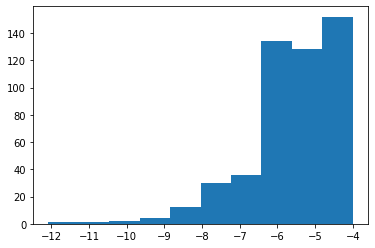

In [7]:
samples = posterior.sample(
    (500,), 
    x=x_o, 
    sample_with='mcmc',
    mcmc_method="nuts", 
    mcmc_parameters={'num_chains': 8, 'thin': 10, 'warmup_steps': 20}
)
log_probability = posterior.log_prob(samples,x=x_o, norm_posterior=False)
plt.hist(log_probability.numpy())

In [8]:
with open(paths.POSTERIOR_SAVE + "log_probability_pm.pkl", "wb") as handle:
    pickle.dump(log_probability, handle)

In [9]:
sample_idx = np.argmax(log_probability)
predicted_post = samples[sample_idx]
predicted_post

tensor([1.0833e-01, 6.2809e+00, 2.1886e+02])

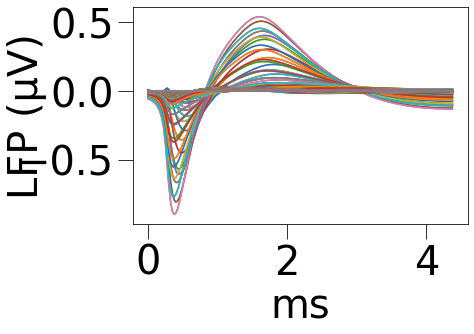

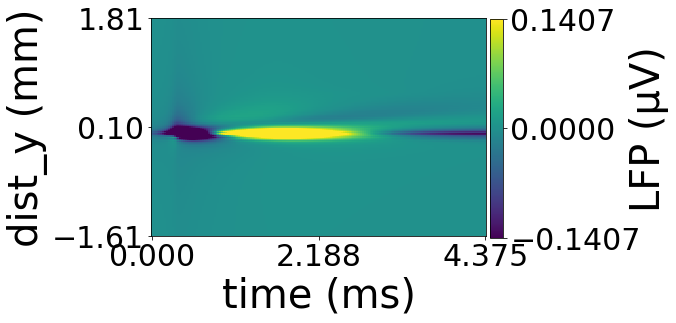

In [10]:
save_xo = params.IM_SAVE_X0
fig,ax = plot_LFP_traces(t0,x0_trace,savefig=params.IM_SAVE_X0)
elec_idx = slice(30,-10)
fig,ax = plot_LFP_heatmap(t0,params.IM_Y_DISTANCE[elec_idx],x0_trace[:,elec_idx],vlim='auto',savefig=params.IM_SAVE_X0)

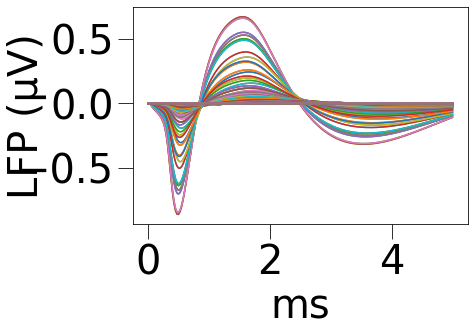

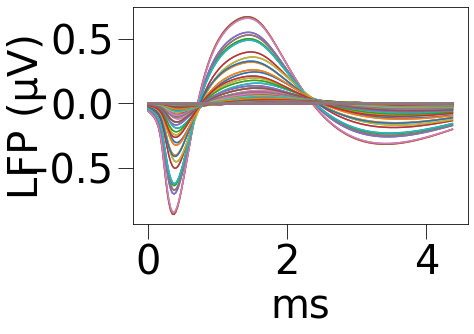

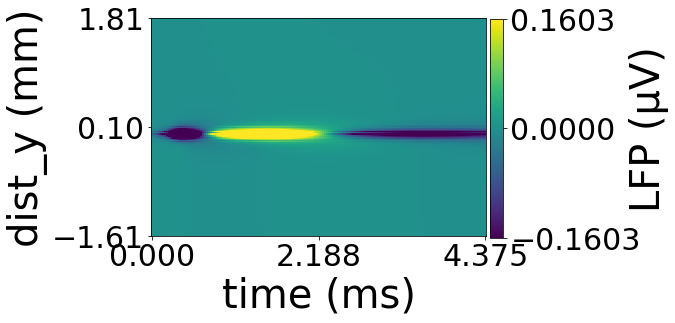

In [11]:
# predicted_lfp = sim_model(params.IM_RANDOM_SAMPLE,whole_trace=True)
predicted_lfp = sim_model(predicted_post,active=params.ACTIVE_CELL,whole_trace=True)

fig,ax = plot_LFP_traces(sim.t(),predicted_lfp)
start,end = get_spike_window(predicted_lfp,win_size=params.AM_WINDOW_SIZE,align_at=fst_idx)
predicted_lfp_win = predicted_lfp[start:end,:]

savefig = paths.PASSIVE_INFERENCE_SAVE_TRACES if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_TRACES
fig,ax = plot_LFP_traces(t0,
                         predicted_lfp_win,
                         savefig=savefig)

savefig = paths.PASSIVE_INFERENCE_SAVE_HEATMAPS if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_HEATMAPS
fig,ax = plot_LFP_heatmap(t0,
                          params.IM_Y_DISTANCE[elec_idx],
                          predicted_lfp_win[:,elec_idx],
                          vlim='auto',
                          savefig=savefig)

In [12]:
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp)
print(max_corr,max_ind)
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp_win)
print(max_corr,max_ind)

0.8769892671589423 1
0.8329756832188348 0


In [13]:
hf_file = paths.PASSIVE_INFERENCE_RESULTS_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_DATA
hf = h5py.File(hf_file, 'w')
hf.create_dataset('LFP',data=predicted_lfp)
hf.create_dataset('samples',data=samples.numpy())
hf.create_dataset('log_prob',data=log_probability.numpy())
hf.close()

mat_file = paths.PASSIVE_INFERENCE_RESULTS_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':predicted_lfp_win[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

mat_file = paths.PASSIVE_INFERENCE_RESULTS_X0_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_X0_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':x0_trace[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

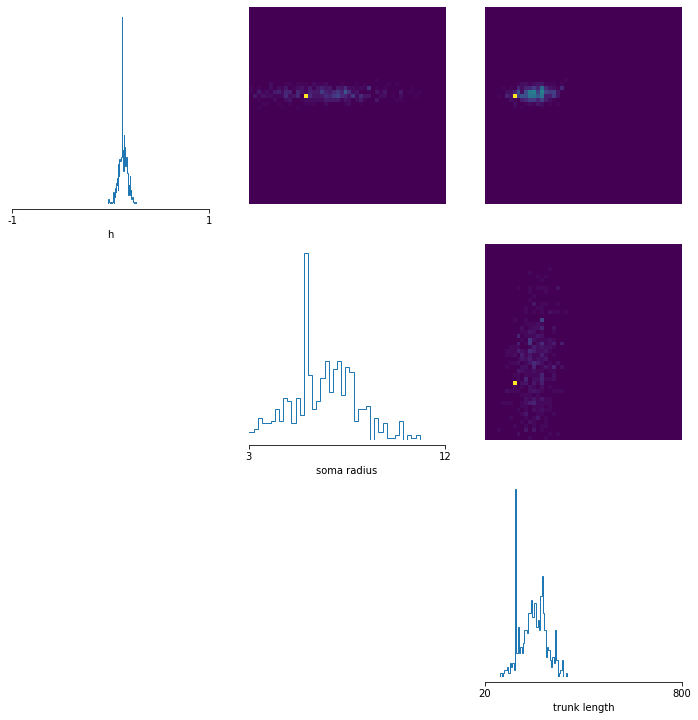

In [14]:
points = torch.Tensor([[1.],[6.0],[600.0]]).reshape(-1,3)#torch.Tensor([[0],[50],[np.pi/4], [0.0], [0.8], [6.0], [400.0], [0.5], [0.5], [0.5], [200.0]]).reshape(-1,11)
labels_params = [r'h',r'soma radius',r'trunk length']
bounds = [[-1,1],[3,12],[20,800]]#[[-2000,2000],[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds,# params.IM_PARAMETER_BOUNDS,
                           ticks = bounds,#params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')

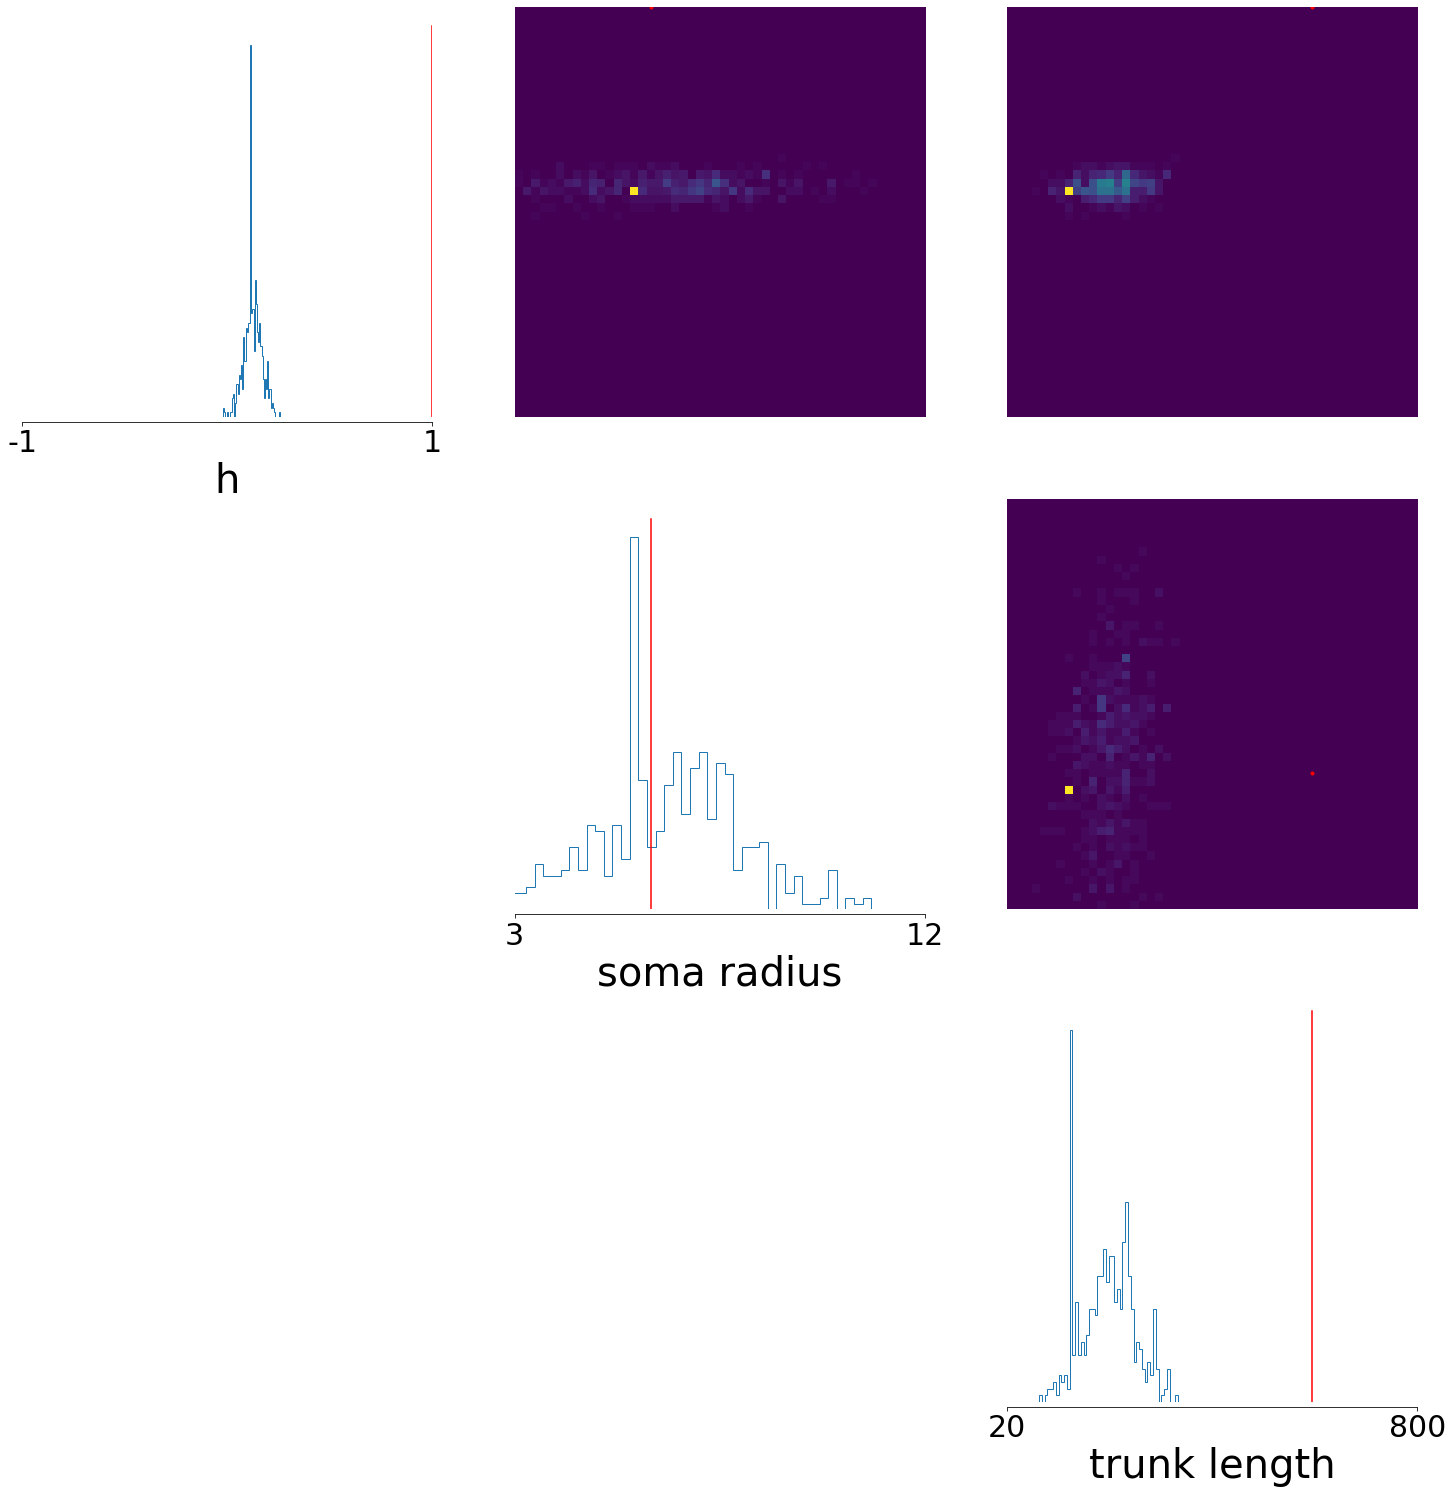

In [15]:
%matplotlib inline

# labels_params = params.IM_GRAPHING_LABELS
points = torch.Tensor([[1.],[6.0],[600.0]]).reshape(-1,3)#torch.Tensor([[0],[50],[np.pi/4], [0.0], [0.8], [6.0], [400.0], [0.5], [0.5], [0.5], [200.0]]).reshape(-1,11)
labels_params = [r'h',r'soma radius',r'trunk length']
bounds = [[-1,1],[3,12],[20,800]]#[[-2000,2000],[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds, #params.IM_PARAMETER_BOUNDS,
                           ticks = bounds, #params.IM_PARAMETER_BOUNDS,
                           figsize=(25,25),
                           points=points,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')

# axes[4][4].set_xlabel('\u03BB',fontsize = 40)
for i in range(len(bounds)):
    axes[i][i].tick_params('x',labelsize=15)
    axes[i][i].xaxis.label.set_fontsize(40)

for i,b in enumerate(bounds):
    axes[i][i].set_xticklabels([str(b[0]),str(b[1])],fontsize=30)

    
save_file = paths.PASSIVE_INFERENCE_SAVE_KDE if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_KDE
plt.savefig(save_file,bbox_inches='tight',transparent=True)

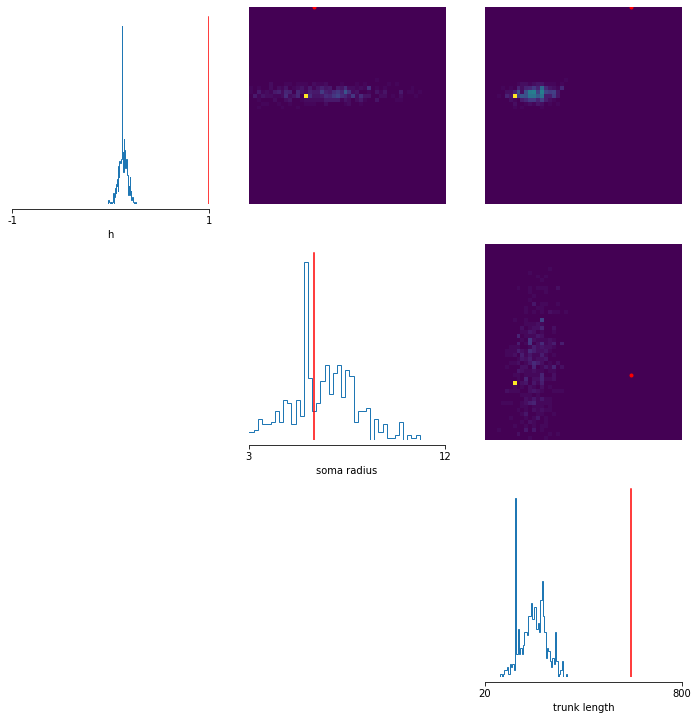

In [16]:
points = torch.Tensor([[1.],[6.0],[600.0]]).reshape(-1,3)#torch.Tensor([[0],[50],[np.pi/4], [0.0], [0.8], [6.0], [400.0], [0.5], [0.5], [0.5], [200.0]]).reshape(-1,11)
labels_params = [r'h',r'soma radius',r'trunk length']
bounds = [[-1,1],[3,12],[20,800]]#[[-2000,2000],[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds,#params.IM_PARAMETER_BOUNDS,
                           ticks = bounds,#params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           points=points,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')